In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
#hdf_path = r'E:/ultimate/day1_streams/masks/df.hdf'
hdf_path = r'E:/ultimate/day1_streams/masks/df2.hdf'

df = pd.read_hdf(hdf_path)
df.head()

#
# Shuffle the rows to get a good spread on pixel samples.
#
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df.head()

hue  hue_east  hue_north  hue_south  hue_west  inmask  saturation  \
0  0.698039  0.698039   0.698039   0.698039  0.698039   False    0.925490   
1  0.690196  0.690196   0.360784   0.690196  0.658824   False    0.968627   
2  0.517647  0.517647   0.517647   0.517647  0.513725   False    0.913725   
3  0.000000  0.000000   0.000000   0.019608  0.690196   False    0.066667   
4  0.478431  0.498039   0.478431   0.478431  0.478431   False    0.231373   

   saturation_east  saturation_north  saturation_south  saturation_west  \
0         0.929412          0.917647          0.937255         0.925490   
1         0.956863          1.000000          0.874510         0.960784   
2         0.929412          0.913725          0.913725         0.913725   
3         0.054902          0.070588          0.043137         0.454902   
4         0.337255          0.231373          0.298039         0.505882   

      value  value_east  value_north  value_south  value_west  
0  0.725490    0.721569     0.729412     0.733333    0.725490  
1  0.054902    0.058824     0.117647     0.062745    0.047059  
2  0.094118    0.094118     0.094118     0.094118    0.101961  
3  1.000000    1.000000     1.000000     1.000000    1.000000  
4  0.796078    0.466667     0.796078     0.592157    0.364706

In [4]:
df['inmask_clean'] = np.where(df['inmask'] == True, 1.0, -1.0)
x_train, x_test = train_test_split(df, test_size=0.3, random_state=int(time.time()))

dt = DecisionTreeClassifier()
used_features = [
    'hue',
    #'hue_east',
    #'hue_north',
    #'hue_south',
    #'hue_west',
    'value',
    #'value_east',
    #'value_north',
    #'value_south',
    #'value_west',
    'saturation',
    #'saturation_east',
    #'saturation_north',
    #'saturation_south',
    #'saturation_west'
]

dt.fit(
    x_train[used_features].values,
    x_train['inmask_clean']
)

y_pred = dt.predict(x_test[used_features])

In [5]:
points = (x_test['inmask_clean'] != y_pred).sum()
print('Number of mislabeled points out of a total {} points: {}'.format(
    x_test.shape[0],
    points
))

Number of mislabeled points out of a total 1617796 points: 29053


In [6]:
print('Performance = {:05.2f}%'.format(100 * (1.0 - float(points) / x_test.shape[0])))

Performance = 98.20%


Huh. That doesn't seem right...

In [7]:
def test_and_plot_image(imgpath, model):
    im = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    flat_hsv = im_hsv.reshape(-1, 3)
    
    hues = []
    values = []
    saturations = []
    inmask = []
    
    img_hues, img_values, img_saturations = np.hsplit(flat_hsv / 255.0, 3)
    temp_df = pd.DataFrame({
        'hue'         : [float(v) for v in img_hues],
        'value'       : [float(v) for v in img_values],
        'saturation'  : [float(v) for v in img_saturations]
    })
    
    pred_mask = np.where(model.predict(temp_df) > 0, 255, 0)
    pred_img = pred_mask.reshape(im_hsv.shape[0], im_hsv.shape[1])
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(im)
    ax[1].imshow(pred_img)

In [8]:
def test_and_plot_image_2(impath, model):
    pass 

# TODO

In [9]:
test_image_path = 'E:/Ultimate/day1_streams/masks/102_58.1.png'
image_mask_dir = 'E:/Ultimate/day1_streams/masks'

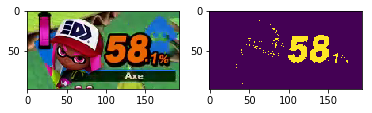

In [10]:
# TODO: Measure perf
test_and_plot_image(test_image_path, dt)

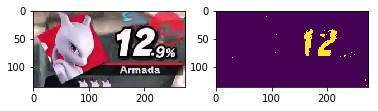

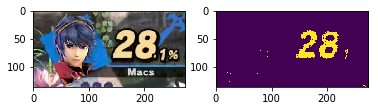

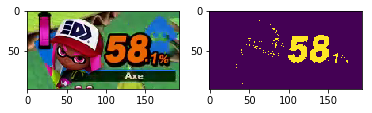

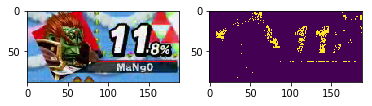

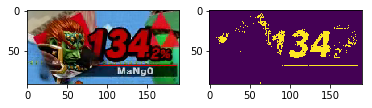

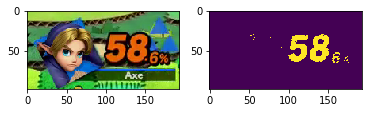

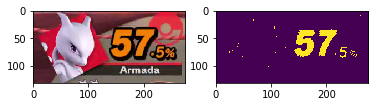

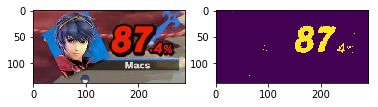

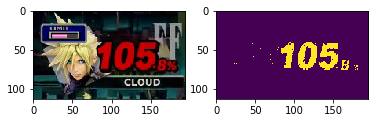

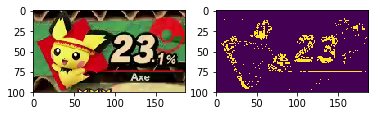

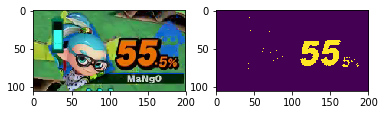

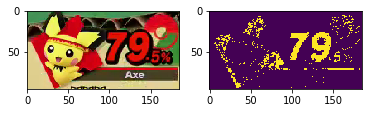

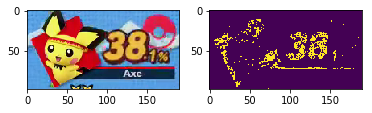

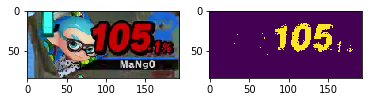

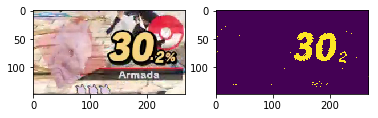

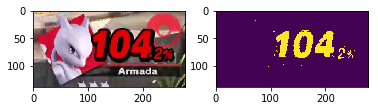

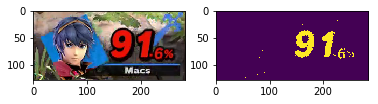

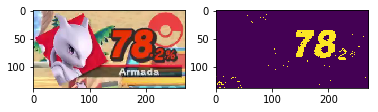

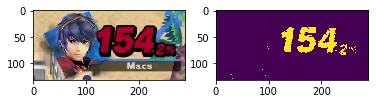

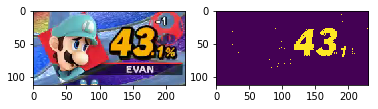

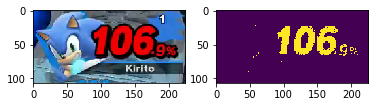

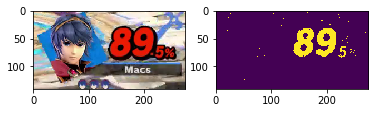

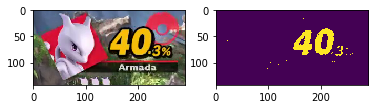

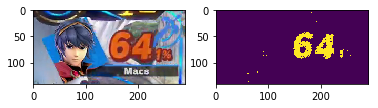

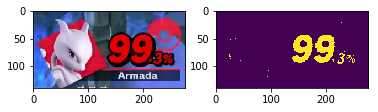

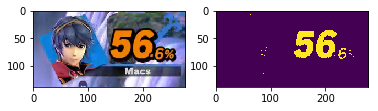

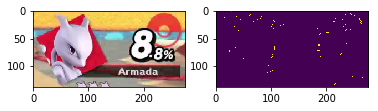

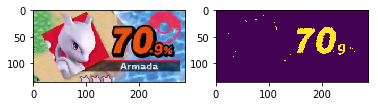

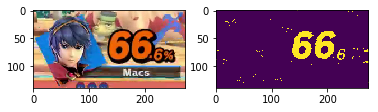

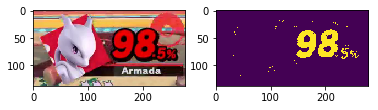

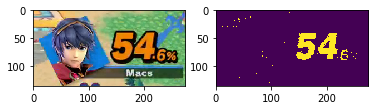

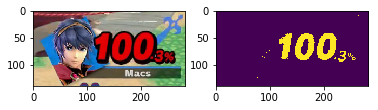

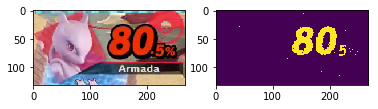

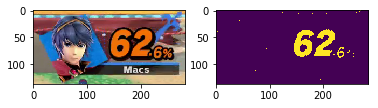

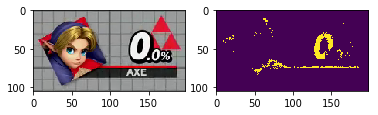

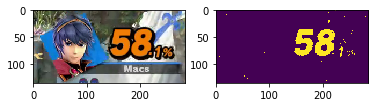

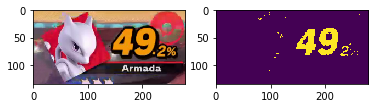

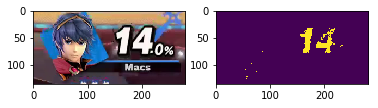

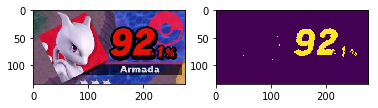

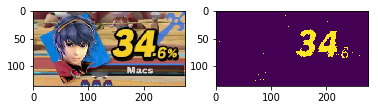

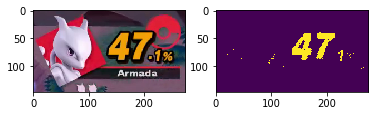

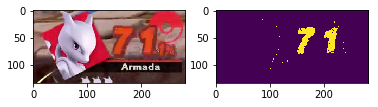

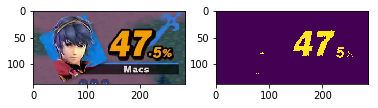

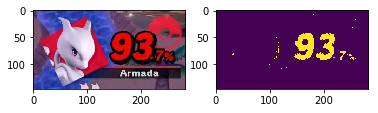

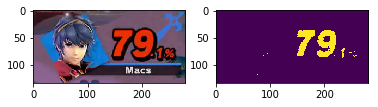

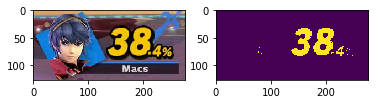

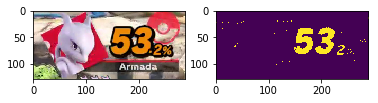

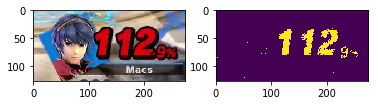

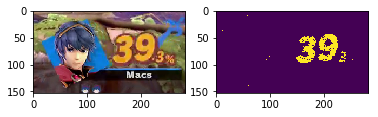

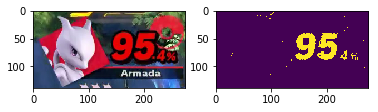

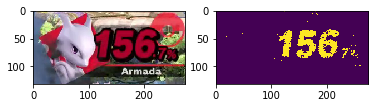

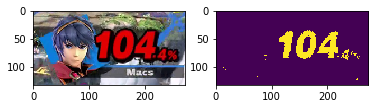

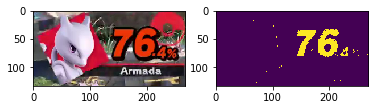

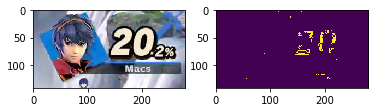

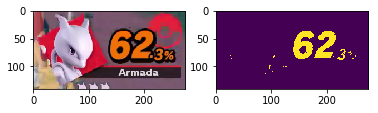

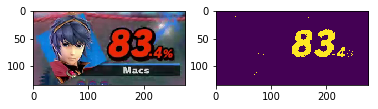

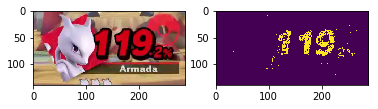

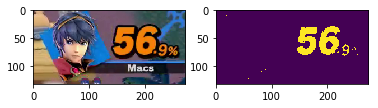

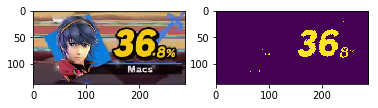

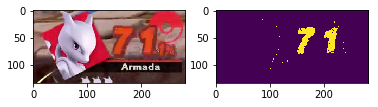

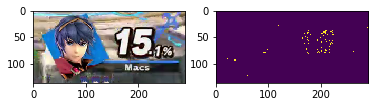

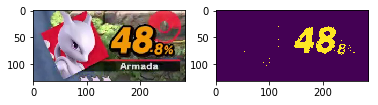

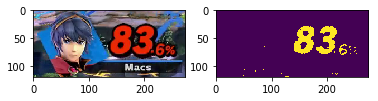

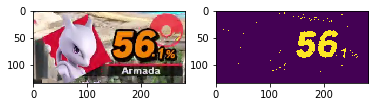

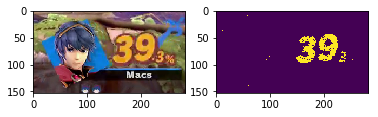

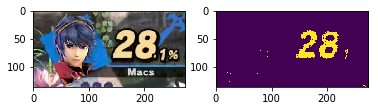

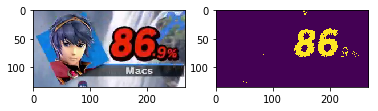

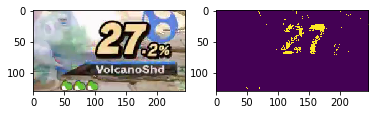

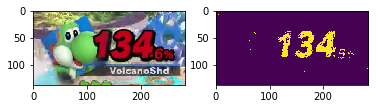

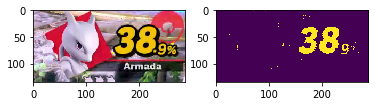

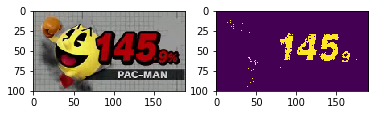

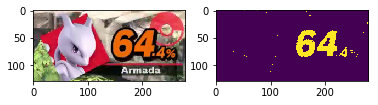

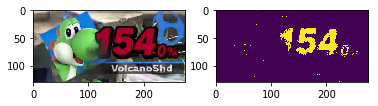

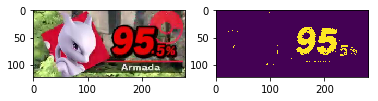

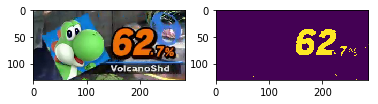

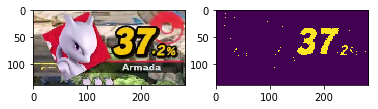

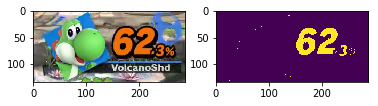

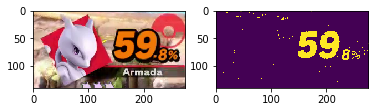

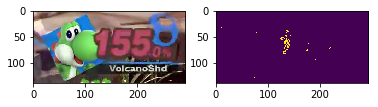

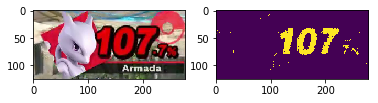

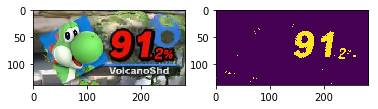

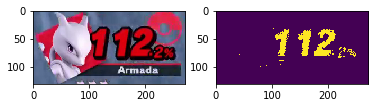

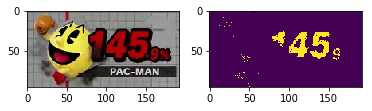

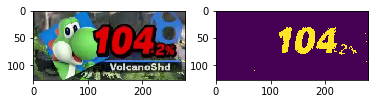

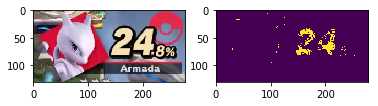

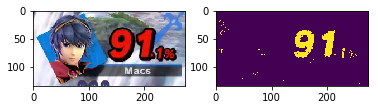

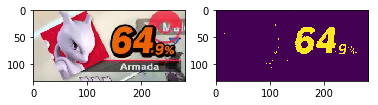

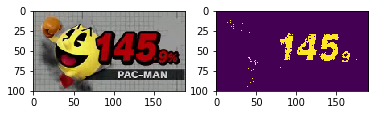

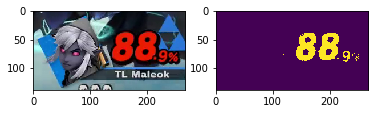

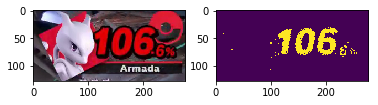

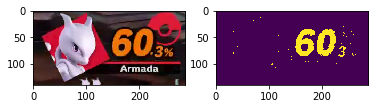

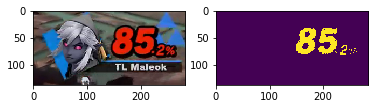

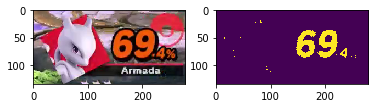

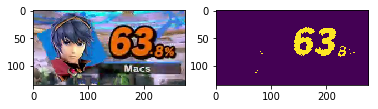

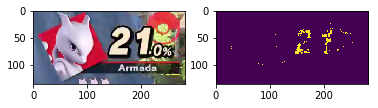

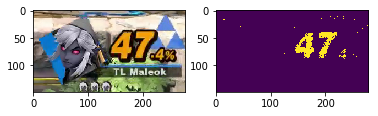

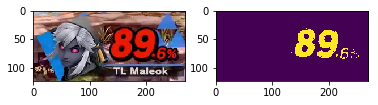

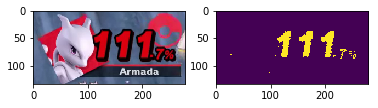

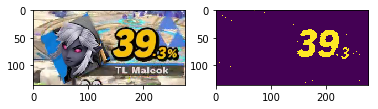

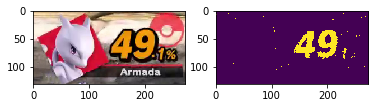

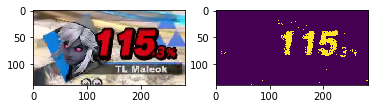

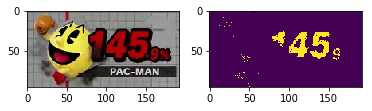

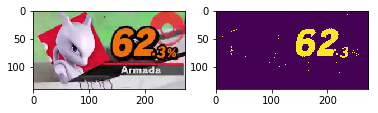

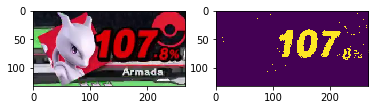

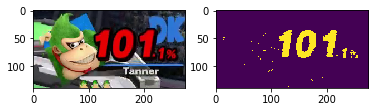

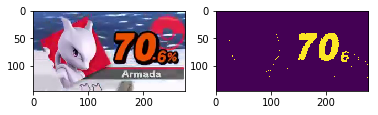

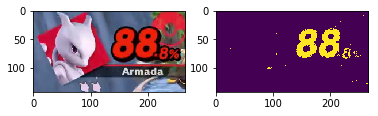

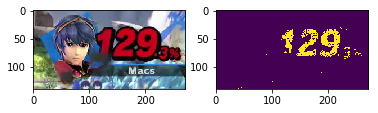

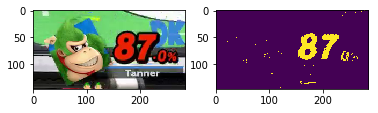

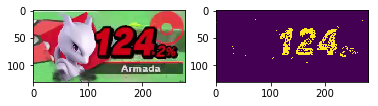

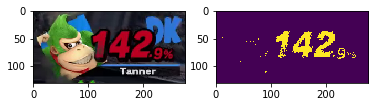

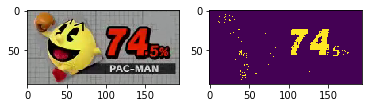

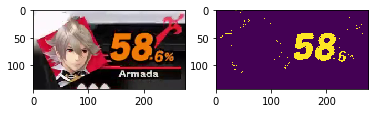

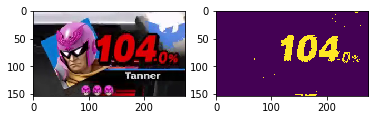

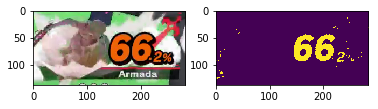

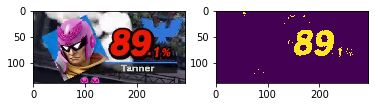

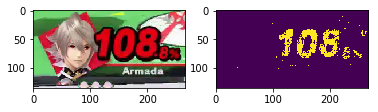

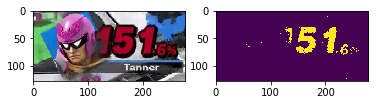

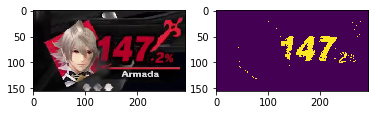

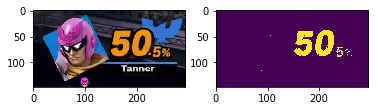

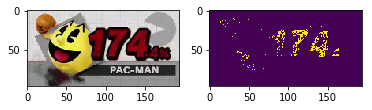

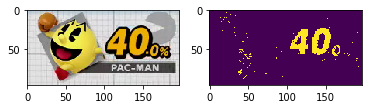

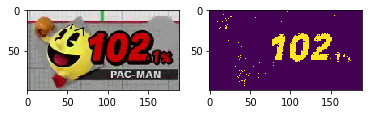

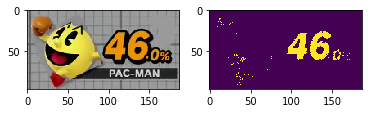

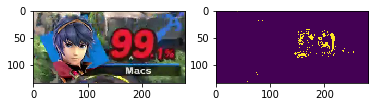

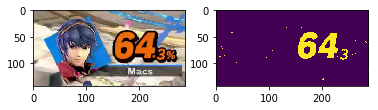

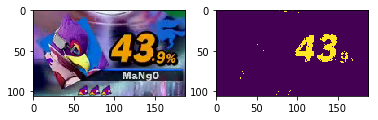

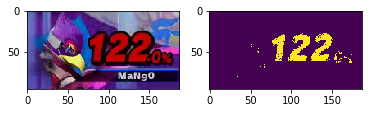

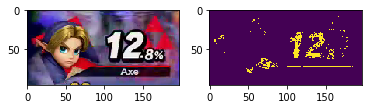

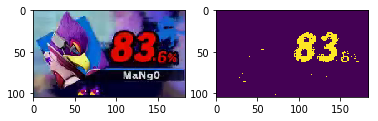

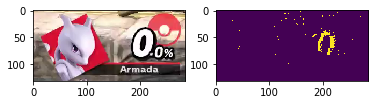

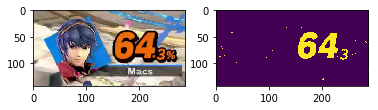

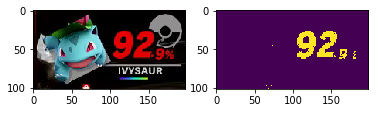

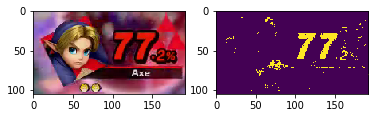

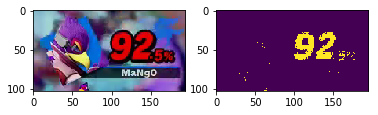

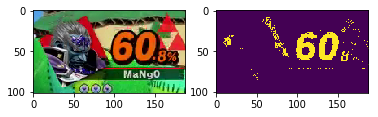

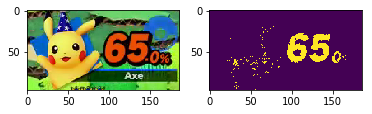

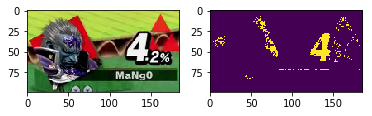

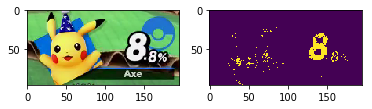

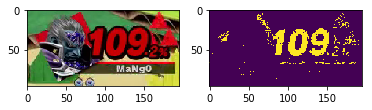

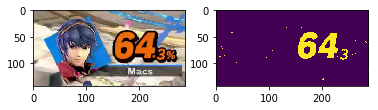

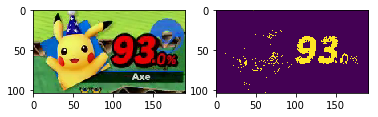

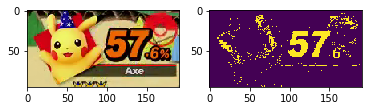

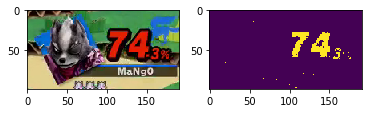

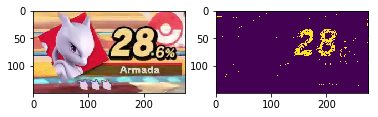

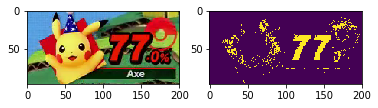

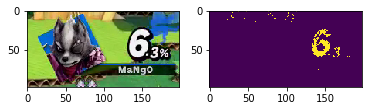

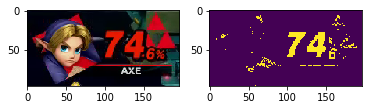

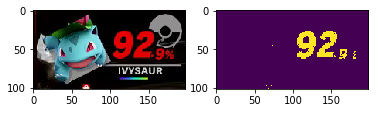

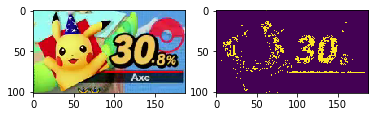

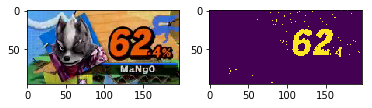

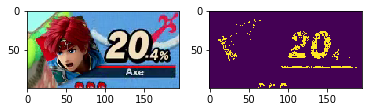

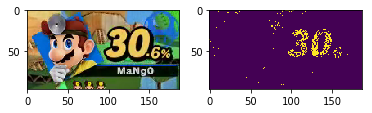

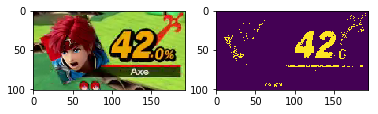

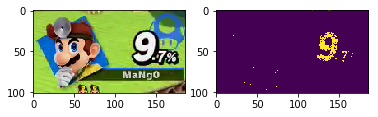

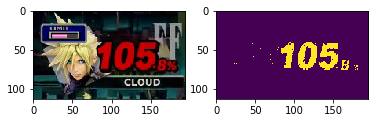

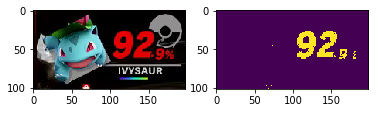

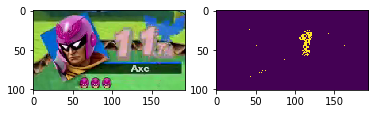

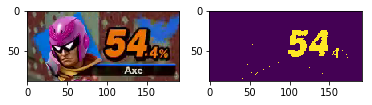

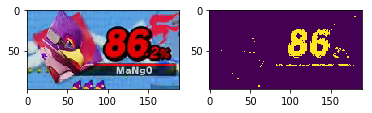

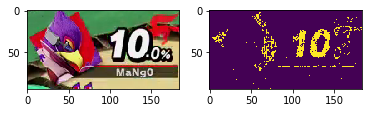

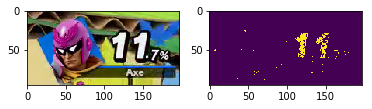

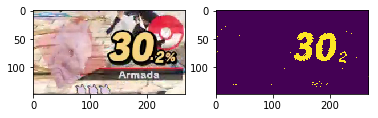

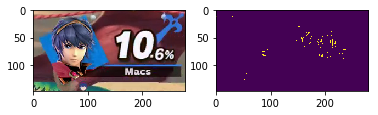

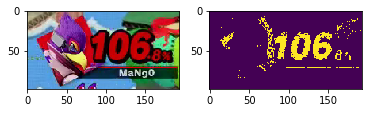

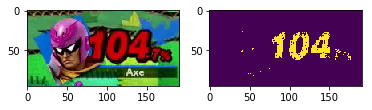

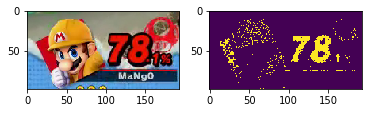

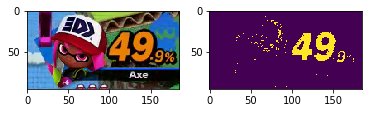

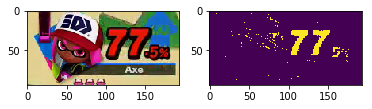

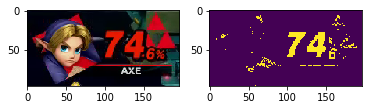

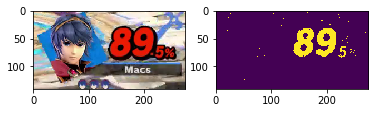

In [11]:
performance = []
for imgfile in [f for f in os.listdir(image_mask_dir) if f[-4:] == ".png" and not "mask" in f]:
    imgpath = os.path.join(image_mask_dir, imgfile)
    test_and_plot_image(imgpath, dt)
    
    #
    # Too many figures, gotta undermine matplotlib's inline plotting to save
    # ram and eliminate some really verbose and annoying warnings.
    #
    plt.show()
    plt.close('all')